## Data Preparation - NYC Airbnb Open Data

**Goal:** Proper ML preprocessing pipeline that prevents data leakage.

**7-Step Pipeline:**
1. Remove impossible values (price ≤ 0, basic validation)
2. **Split train/test EARLY** ← Prevents leakage!
3. Impute missing values (fit on TRAIN only)
4. Handle outliers using IQR (calculate on TRAIN only)
5. Feature binning (if useful)
6. Scale numerical features (fit on TRAIN only)
7. Encode categorical features (fit on TRAIN only)

**Key Principle:** ALL statistics calculated on TRAIN only, then applied to TEST.

**Outputs:**
- Preprocessor: `artifacts/preprocessor.joblib`
- Feature names: `artifacts/feature_names.json`
- Price bins: `artifacts/price_bin_thresholds.json`
- Arrays: `X_train/test_reg/cls.npz`, `y_train/test_reg/cls.npz`

### 00 - Import Dependencies

In [261]:
# Imports
import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Imports Loaded!!!")


"""
import kagglehub
from kagglehub import KaggleDatasetAdapte
file_path = "data/raw"
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "dgomonov/new-york-city-airbnb-open-data",
  file_path,)
"""


Imports Loaded!!!


'\nimport kagglehub\nfrom kagglehub import KaggleDatasetAdapte\nfile_path = "data/raw"\ndf = kagglehub.load_dataset(\n  KaggleDatasetAdapter.PANDAS,\n  "dgomonov/new-york-city-airbnb-open-data",\n  file_path,)\n'

### 01 - Configuration

In [ ]:
#Paths
RAW_DATA_PATH = 'data/raw/AB_NYC_2019.csv'
PROCESSED_DIR = Path('data/processed')
ARTIFACTS_DIR = Path('artifacts')
FIGURE_DIR = Path('figures')

# Create directories
# for dir_path in [PROCESSED_DIR, ARTIFACTS_DIR, FIGURES_DIR]:
#     dir_path.mkdir(parents=True, exist_ok=True)
#     # Clear all files in directory
#     for file in dir_path.glob('*'):
#         if file.is_file():
#             file.unlink()

PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
FIGURE_DIR.mkdir(parents=True, exist_ok=True)

# Constants
NYC_LAT_MIN, NYC_LAT_MAX = 40.4, 41.0
NYC_LON_MIN, NYC_LON_MAX = -74.3, -73.6
IQR_MULTIPLIER = 1.5

print("Paths / Directories configured...")

Paths / Directories configured...


### 02 - Load Raw Data

In [263]:
df_raw = pd.read_csv(RAW_DATA_PATH)
df_raw.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [264]:
df_raw = df_raw.drop(columns=['id', 'name', 'host_id', 'host_name'])
df_raw.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [265]:
columns = df_raw.columns.values
print(f"========== Columns Identified ==========\n{columns}")

print(f"\nNumber of Samples : {len(df_raw)}")
print(f"Number of Columns :{len(columns)}")


========== Columns Identified ==========
['neighbourhood_group' 'neighbourhood' 'latitude' 'longitude' 'room_type'
 'price' 'minimum_nights' 'number_of_reviews' 'last_review'
 'reviews_per_month' 'calculated_host_listings_count' 'availability_365']

Number of Samples : 48895
Number of Columns :12


### 03 - Missing Values & Extreme Outlier Analysis

In [266]:
missing_df = df_raw.isnull().sum()
missing_df

neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [267]:
missing_df /= len(df_raw)
missing_df *= 100
missing_df

neighbourhood_group                0.000000
neighbourhood                      0.000000
latitude                           0.000000
longitude                          0.000000
room_type                          0.000000
price                              0.000000
minimum_nights                     0.000000
number_of_reviews                  0.000000
last_review                       20.558339
reviews_per_month                 20.558339
calculated_host_listings_count     0.000000
availability_365                   0.000000
dtype: float64

#### Columns need to handle immidiately
- price <=> 0 [Drop]
- avalability_365 <= 0 [Impute with Median]
- last_review [Impute]
- reviews_per_month [Impute]
- location should be within NYC

In [268]:
#print(sum(df_raw['price'] <= 0))
#print(sum(df_raw['availability_365'] <=0))
#df_raw[df_raw['availability_365'] <=0]

In [269]:
def remove_impossible_values(
                             df,
                             NYC_LAT_MIN = 40.4,
                             NYC_LAT_MAX = 41.0,
                             NYC_LON_MIN = -74.3,
                             NYC_LON_MAX= -73.66 
                             ): 
    price_removed = df[df['price'] <= 0]
    print(f"Samples dropped : price <= 0 is {len(price_removed)}")
    
    df = df[df['price'] > 0]
    count_prior_loc_filter = len(df)
    df = df[
            (df['latitude'].between(NYC_LAT_MIN, NYC_LAT_MAX)) &
            (df['longitude'].between(NYC_LON_MIN, NYC_LON_MAX))
            ]
    print(f"Samples dropped : Location out of NYC is {count_prior_loc_filter - len(df)}")
    return df

In [270]:
df_raw = remove_impossible_values(df_raw)
df_raw.head()
# No OUT OF NYC locations btw.

Samples dropped : price <= 0 is 11
Samples dropped : Location out of NYC is 0


,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


### 04 - Exploration Data Analysis

#### Step 01 : Summary

In [271]:
print("========== Raw Data Summery ==========")
df_raw.describe()

========== Raw Data Summery ==========


,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000,38833.000000,48884.000000,48884.000000
mean,40.728953,-73.952176,152.755053,7.029887,23.271991,1.373128,7.144628,112.779498
std,0.054532,0.046159,240.170260,20.512224,44.551331,1.680391,32.956185,131.627271
min,40.499790,-74.244420,10.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,40.690100,-73.983080,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,40.723080,-73.955685,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,40.763120,-73.936290,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


<function matplotlib.pyplot.show(close=None, block=None)>

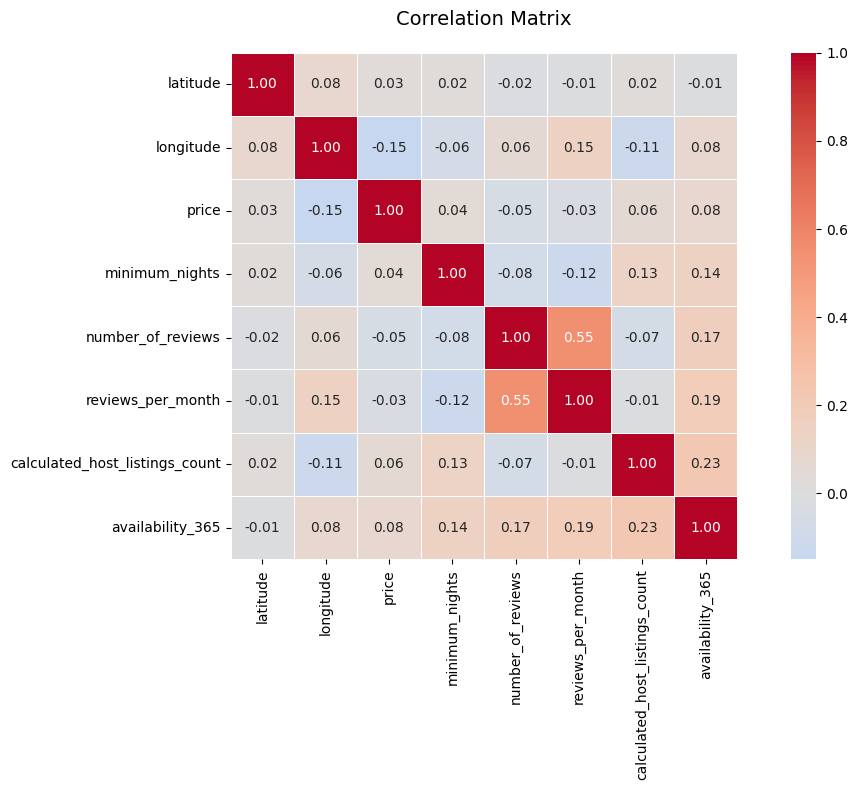

In [272]:
#print(df_raw.columns)
plt.figure(figsize=(12, 8))
# Numerical Columns
num_columns = df_raw.select_dtypes(include=['int64', 'float64']).columns
df_num = df_raw[num_columns]

corr_matrix = df_num.corr()
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    center=0,
    fmt='.2f',
    square=True,
    linewidths=0.5
    )
plt.title("Correlation Matrix", fontsize=14, pad=20)
plt.tight_layout()
plt.savefig(FIGURE_DIR / 'coreelation_map.png', dpi=150, bbox_inches="tight")
plt.show

#### Step 02 : Data Splitting

In [273]:
OUTPUT_COLS = ['price']

"""
There're 2 types of Input Columns
    01. Numeric Columns
    02. Categorical Columns
        a. Normal Columns (No Specific Order)
        b. Ordinal Columns (Specific Order)       
"""

NORMAL_COLS = [
            'neighbourhood_group',
            'neighbourhood'
            ]

ORDINAL_COLS = ['room_type']
ORDINAL_CATEGORIES = [['Shared room', 'Private room', 'Entire home/apt']]
NUMERIC_COLS = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 
                'calculated_host_listings_count', 'availability_365']
IMPUTE_COLS = ['last_review', 'reviews_per_month']

X = df_raw[NORMAL_COLS + ORDINAL_COLS + NUMERIC_COLS + IMPUTE_COLS]
Y = df_raw[OUTPUT_COLS]

X_train, X_test, Y_train, Y_test = train_test_split(
                                                    X,
                                                    Y,
                                                    test_size=0.2,
                                                    random_state=RANDOM_STATE
                                                   )

print(f"    TRAIN SIZE : {len(Y_train)} samples")
print(f"    TEST SIZE : {len(Y_test)} samples")



    TRAIN SIZE : 39107 samples
    TEST SIZE : 9777 samples


#### Step 03 : Data Imputation

#### Columns need to impute
- availability_365 <= 0 [Impute with Median]
- last_review [Impute]
- reviews_per_months [Impute]

In [274]:
X_train['last_review'] = pd.to_datetime(X_train['last_review'], errors='coerce')
X_test['last_review']= pd.to_datetime(X_test['last_review'], errors = 'coerce')

max_date_train = X_train['last_review'].max() 
X_train['days_since_last_review'] = (max_date_train - X_train['last_review']).dt.days
X_train['days_since_last_review'].fillna(X_train['days_since_last_review'].max(), inplace=True)
del X_train['last_review']

X_test['days_since_last_review'] = (max_date_train - X_test['last_review']).dt.days
X_test['days_since_last_review'].fillna(X_test['days_since_last_review'].max(), inplace=True)
del X_test['last_review']


In [275]:
median_availability_365 = X_train.loc[X_train['availability_365'] >0, 'availability_365'].median()
median_availability_365 = float(median_availability_365)

X_train.loc[X_train['availability_365'] <=0, 'availability_365'] = median_availability_365
X_test.loc[X_test['availability_365'] <= 0, 'availability_365'] = median_availability_365

In [276]:
X_train.loc[X_train['number_of_reviews'] == 0, 'reviews_per_month'] = 0
median_reviews_per_month = X_train['reviews_per_month'].median()
X_train['reviews_per_month'].fillna(median_reviews_per_month, inplace=True)

X_test.loc[X_test['number_of_reviews'] == 0, 'reviews_per_month'] = 0
X_test['reviews_per_month'].fillna(X_train['reviews_per_month'].median(), inplace=True)

Verify Handliing Missing Values

In [277]:
X_train_ver_mis_val = X_train.isnull().sum()
X_train_ver_mis_val /= len(X_train)
X_train_ver_mis_val *= 100
X_train_ver_mis_val

neighbourhood_group               0.0
neighbourhood                     0.0
room_type                         0.0
latitude                          0.0
longitude                         0.0
minimum_nights                    0.0
number_of_reviews                 0.0
calculated_host_listings_count    0.0
availability_365                  0.0
reviews_per_month                 0.0
days_since_last_review            0.0
dtype: float64

#### Step 04 : Handling Outliers

#### Calculate IQR Bounds

# ![IQR Outlier Detection](https://docs.oracle.com/en/cloud/saas/tax-reporting-cloud/ustrc/img/insights_iqr_example.jpg)

In [278]:
#MULTIPLIER = 1.5 - orginal value for IQR, But according to the domain u can choose optimal value
MULTIPLIER = 2.2
Q1, Q3 = Y_train.quantile([0.25, 0.75]).values.squeeze()
IQR = Q3 - Q1

"""
Not to be an outliers, price need to be in-between
"""
# LB_IQR = lower bound IQR, UB_IQR = upper bound IQR
LB_IQR = Q1 - MULTIPLIER * IQR
UB_IQR = Q3 + MULTIPLIER * IQR

print(f"Lower Bound IQR  : {LB_IQR}")
print(f"Upper Bound IQR  : {UB_IQR}")

Lower Bound IQR  : -164.20000000000002
Upper Bound IQR  : 408.20000000000005


In [279]:
X_train, Y_train

X_train.reset_index(inplace=True, drop=True)
Y_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
Y_test.reset_index(inplace=True, drop=True)

In [280]:
train_outliers =((Y_train < LB_IQR) | (Y_train > UB_IQR))
test_outliers = ((Y_test < LB_IQR) | (Y_test > UB_IQR))
print(f"Outliers detected : TRAIN = {train_outliers.sum()}, TEST = {test_outliers.sum()}")

Outliers detected : TRAIN = price    1406
dtype: int64, TEST = price    347
dtype: int64


In [281]:
Y_train, Y_test = Y_train.iloc[~train_outliers.index], Y_test.iloc[~test_outliers.index]
X_train, X_test = X_train.iloc[~train_outliers.index], X_test.iloc[~test_outliers.index]

print("OutlierRemovel ==>")
print(f"    TRAIN SIZE : {len(Y_train)} samples")
print(f"    TEST SIZE : {len(Y_test)} samples")

OutlierRemovel ==>
    TRAIN SIZE : 39107 samples
    TEST SIZE : 9777 samples


#### Step 05 : Encoding & Scaling

In [282]:
X_train

,neighbourhood_group,neighbourhood,room_type,latitude,longitude,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,reviews_per_month,days_since_last_review
39106,Queens,Long Island City,Entire home/apt,40.74657,-73.94555,5,1,1,169,0.03,1114.0
39105,Manhattan,Upper West Side,Entire home/apt,40.77508,-73.97990,2,11,1,2,0.13,29.0
39104,Bronx,Fieldston,Shared room,40.89466,-73.89735,1,8,2,241,1.26,2.0
39103,Manhattan,West Village,Entire home/apt,40.73916,-74.00511,2,1,1,61,0.88,33.0
39102,Manhattan,Washington Heights,Shared room,40.84650,-73.94319,1,0,1,169,0.00,2996.0
...,...,...,...,...,...,...,...,...,...,...,...
4,Brooklyn,Park Slope,Private room,40.67075,-73.97690,1,0,4,169,0.00,2996.0
3,Manhattan,Chelsea,Private room,40.74526,-73.99545,14,1,1,169,0.02,1284.0
2,Bronx,Woodlawn,Private room,40.89981,-73.86684,2,7,1,70,1.84,35.0
1,Brooklyn,Williamsburg,Private room,40.70343,-73.93412,5,5,1,169,0.35,224.0


In [283]:
NORMINAL_COLS = [
            'neighbourhood_group',
            'neighbourhood'
            ]
ORDINAL_COLS = ['room_type']
ORDINAL_CATEGORIES = [['Shared room', 'Private room', 'Entire home/apt']]
NUMERIC_COLS = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 
                'calculated_host_listings_count', 'availability_365',
                'reviews_per_month', 'days_since_last_review']


In [284]:
tranformers = [
            # For numerical columns
            (
            'num', Pipeline(
                            [
                                ('scaler', StandardScaler())
                            ]
                            ),
            NUMERIC_COLS
            ),
            # For Norminal columns
            (
            'nom', Pipeline(
                            [
                                ('onehot', OneHotEncoder(handle_unknown='ignore',min_frequency=0.01,sparse_output=False))
                            ]
                            ),
            NORMINAL_COLS
            ),
            # For ordinal columns
            (
            'ord', Pipeline(
                            [
                                ('onehot', OrdinalEncoder(categories=ORDINAL_CATEGORIES, handle_unknown='use_encoded_value', unknown_value=-1))
                            ]
                            ),
            ORDINAL_COLS
            )
]

preprocesser = ColumnTransformer(tranformers)

In [285]:
preprocesser.fit(X_train)

,transformers,"[('num', ...), ('nom', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


In [286]:
feature_names = []
for name, tranformer, columns in preprocesser.transformers_:
    if name == 'num':
        feature_names.extend(columns)
    elif name == 'nom':
        feature_names.extend(tranformer.named_steps['onehot'].get_feature_names_out(columns))
    elif name == 'ord':
        feature_names.extend(columns)
feature_names
# len(feature names)
# 39 features 

['latitude',
 'longitude',
 'minimum_nights',
 'number_of_reviews',
 'calculated_host_listings_count',
 'availability_365',
 'reviews_per_month',
 'days_since_last_review',
 'neighbourhood_group_Bronx',
 'neighbourhood_group_Brooklyn',
 'neighbourhood_group_Manhattan',
 'neighbourhood_group_Queens',
 'neighbourhood_group_infrequent_sklearn',
 'neighbourhood_Astoria',
 'neighbourhood_Bedford-Stuyvesant',
 'neighbourhood_Bushwick',
 'neighbourhood_Chelsea',
 'neighbourhood_Clinton Hill',
 'neighbourhood_Crown Heights',
 'neighbourhood_East Flatbush',
 'neighbourhood_East Harlem',
 'neighbourhood_East Village',
 'neighbourhood_Financial District',
 'neighbourhood_Flatbush',
 'neighbourhood_Greenpoint',
 'neighbourhood_Harlem',
 "neighbourhood_Hell's Kitchen",
 'neighbourhood_Long Island City',
 'neighbourhood_Lower East Side',
 'neighbourhood_Midtown',
 'neighbourhood_Park Slope',
 'neighbourhood_Prospect-Lefferts Gardens',
 'neighbourhood_Upper East Side',
 'neighbourhood_Upper West Side

In [287]:
X_train_transform = preprocesser.transform(X_train)
X_test_transform = preprocesser.transform(X_test)

In [288]:
X_train_transform = pd.DataFrame(X_train_transform, columns=feature_names)
X_test_transform = pd.DataFrame(X_test_transform, columns=feature_names)

In [289]:
X_train_transform

,latitude,longitude,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,reviews_per_month,days_since_last_review,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,...,neighbourhood_Midtown,neighbourhood_Park Slope,neighbourhood_Prospect-Lefferts Gardens,neighbourhood_Upper East Side,neighbourhood_Upper West Side,neighbourhood_Washington Heights,neighbourhood_West Village,neighbourhood_Williamsburg,neighbourhood_infrequent_sklearn,room_type
0,0.321819,0.141769,-0.100454,-0.499567,-0.186526,-0.045545,-0.659564,0.242663,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1,0.844591,-0.603609,-0.243245,-0.275289,-0.186526,-1.693754,-0.597661,-0.694173,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
2,3.037262,1.187685,-0.290842,-0.342573,-0.156049,0.665061,0.101845,-0.717486,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.185946,-1.150653,-0.243245,-0.499567,-0.186526,-1.111453,-0.133387,-0.690719,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0
4,2.154179,0.192980,-0.290842,-0.521995,-0.186526,-0.045545,-0.678135,1.867663,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39102,-1.068450,-0.538510,-0.290842,-0.521995,-0.095097,-0.045545,-0.678135,1.867663,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
39103,0.297798,-0.941036,0.327918,-0.499567,-0.186526,-0.045545,-0.665754,0.389448,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
39104,3.131694,1.849736,-0.243245,-0.365000,-0.186526,-1.022627,0.460883,-0.688992,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
39105,-0.469215,0.389794,-0.100454,-0.409856,-0.186526,-0.045545,-0.461474,-0.525802,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


#### Step 06 (Bonus)  : Derrive ClassificationTarget [with Feature Binning]

In [290]:
Q33, Q66 = Y_train.quantile([0.33, 0.66]).values.squeeze()
print(f"Price quantiles (TRAIN) : q33=${Q33:.0f}, q66=${Q66:.0f}")

Price quantiles (TRAIN) : q33=$80, q66=$150


In [291]:
def binning_price(y, Q33, Q66):
    return pd.cut(
                    y.values.squeeze(),
                    bins=[0, Q33, Q66, np.inf],
                    labels=['Budget', 'Standed', 'Luxury'],
                    include_lowest=True
                    )

Y_train_cat = binning_price(Y_train, Q33, Q66)
Y_test_cat = binning_price(Y_test, Q33, Q66)

In [292]:
Y_train

,price
39106,120
39105,150
39104,50
39103,250
39102,60
...,...
4,149
3,140
2,80
1,45


In [293]:
Y_train_cat

['Standed', 'Standed', 'Budget', 'Luxury', 'Budget', ..., 'Standed', 'Standed', 'Budget', 'Budget', 'Budget']
Length: 39107
Categories (3, object): ['Budget' < 'Standed' < 'Luxury']

In [294]:
Y_test_cat  

['Budget', 'Budget', 'Standed', 'Standed', 'Standed', ..., 'Standed', 'Budget', 'Budget', 'Standed', 'Standed']
Length: 9777
Categories (3, object): ['Budget' < 'Standed' < 'Luxury']

#### Step 07 : Save Artifacts

In [300]:
np.savez_compressed(ARTIFACTS_DIR / 'X_train.npz', data=X_train_transform)
np.savez_compressed(ARTIFACTS_DIR / 'X_test.npz', data=X_test_transform)

np.savez_compressed(ARTIFACTS_DIR / 'y_train_regression.npz', data=Y_train.values)
np.savez_compressed(ARTIFACTS_DIR / 'y_test_regression.npz', data=Y_test.values)

np.savez_compressed(ARTIFACTS_DIR / 'y_train_classificatin.npz', data=Y_train_cat.codes)
np.savez_compressed(ARTIFACTS_DIR / 'y_test_classificatin.npz', data=Y_test_cat.codes)

with open (ARTIFACTS_DIR / 'preprrocessor.joblib', 'wb') as f:
    joblib.dump(preprocesser, f)